In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os

import uproot
print(uproot.__version__)
import histlite as hl

import scipy.interpolate as interp

from scipy.optimize import curve_fit

from matplotlib import colors


plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (7,6)

plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (10,8)


def Gaussian( x, A, mu, sig ):
    
    return A * np.exp(-(x-mu)**2/(2*sig**2))


3.11.1


# Getting an idea of PH values for given neutron energy event in the neutron detectors

Using high current data for this


In [2]:
replayed_data_dir = '/global/cfs/cdirs/lux/users/haselsco/TUNL_August_2021_Data/replayed/slurm_run30177/'

rootfiles = [filename for filename in os.listdir(replayed_data_dir) \
                                         if filename.endswith('.root')]


In [3]:
data_list = []

n_open = 187

print('{} files found.'.format(len(rootfiles)))
print('only opening {} of these...'.format(n_open))
for i,thisfile in enumerate(rootfiles[:n_open]):
    if i % 10 == 0:
        print('Opening {} of {}'.format(i,len(rootfiles)))
    
    fullpath = replayed_data_dir + thisfile
    
    data_list.append( uproot.open(fullpath)['ndet_events'].arrays( ["*"], outputtype=pd.DataFrame ) )
    


187 files found.
only opening 187 of these...
Opening 0 of 187
Opening 10 of 187
Opening 20 of 187
Opening 30 of 187
Opening 40 of 187
Opening 50 of 187
Opening 60 of 187
Opening 70 of 187
Opening 80 of 187
Opening 90 of 187
Opening 100 of 187
Opening 110 of 187
Opening 120 of 187
Opening 130 of 187
Opening 140 of 187
Opening 150 of 187
Opening 160 of 187
Opening 170 of 187
Opening 180 of 187


In [4]:
data = pd.concat(data_list,ignore_index=True)

data.head()

,ndet_ch,ndet_PH,ndet_E,ndet_ts,ndet_tof,ndet_PSD,ndet_PSD_cut,ndet_flash,ndet_true_time
0,16.0,2091.0,0.0,1.662132e+12,515.383591,4.031119,9.25,2456.0,1259.383591
1,21.0,1137.0,0.0,1.662134e+12,448.110385,4.547932,9.00,2446.0,1202.110385
2,17.0,1759.0,0.0,1.662144e+12,2912.669775,5.472800,10.50,2450.0,462.669775
3,18.0,1194.0,0.0,1.662156e+12,3146.195472,6.325545,9.50,2436.0,710.195472
4,20.0,3542.0,0.0,1.662163e+12,2860.278202,4.734524,9.00,2444.0,416.278202


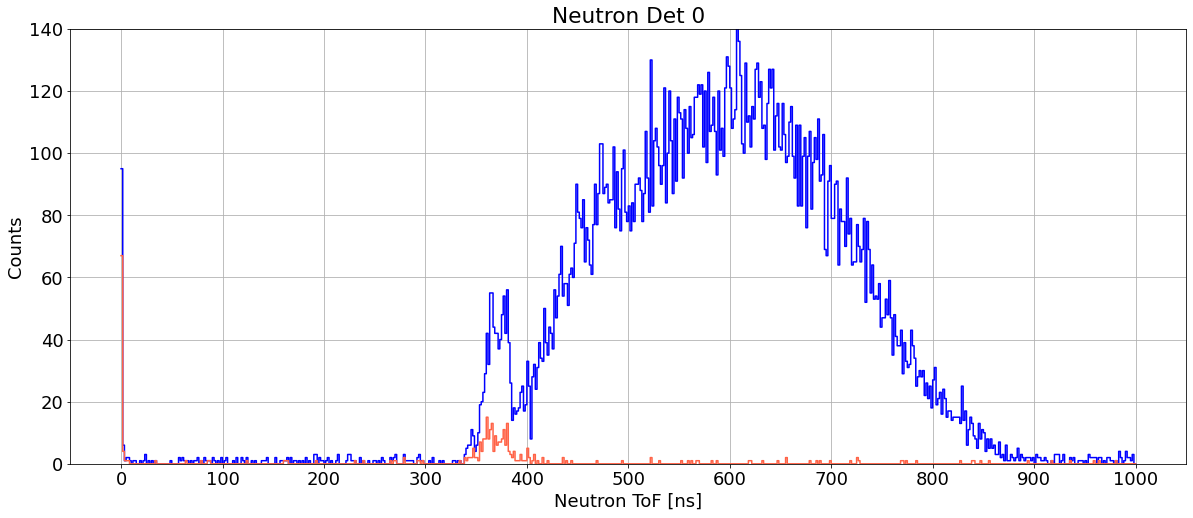

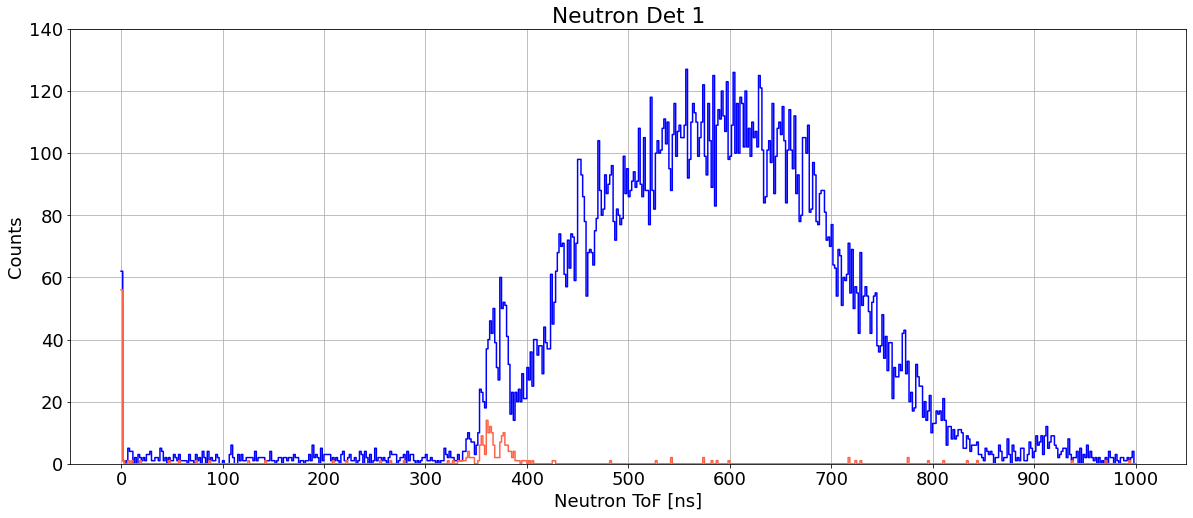

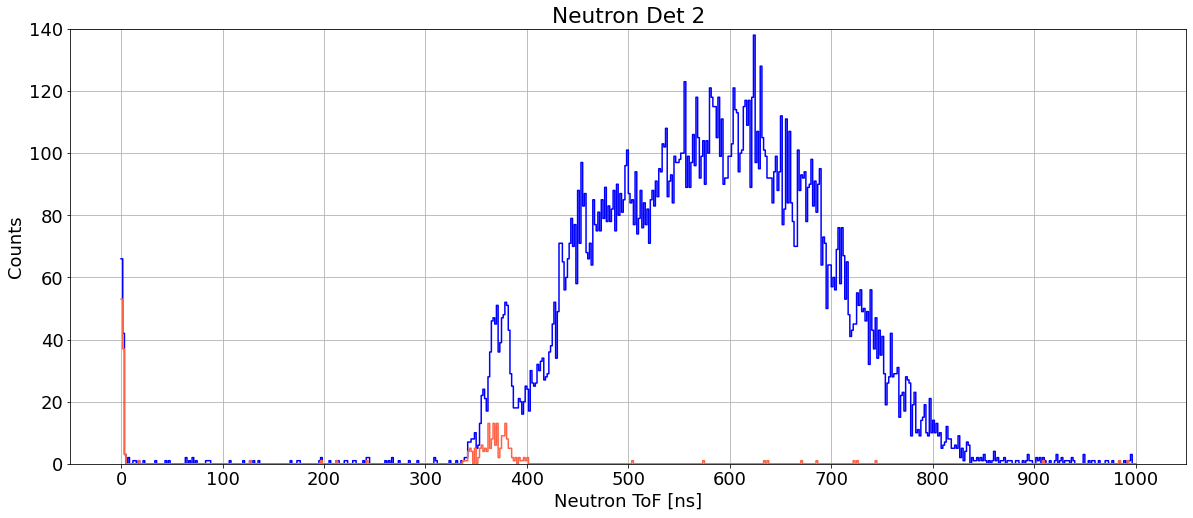

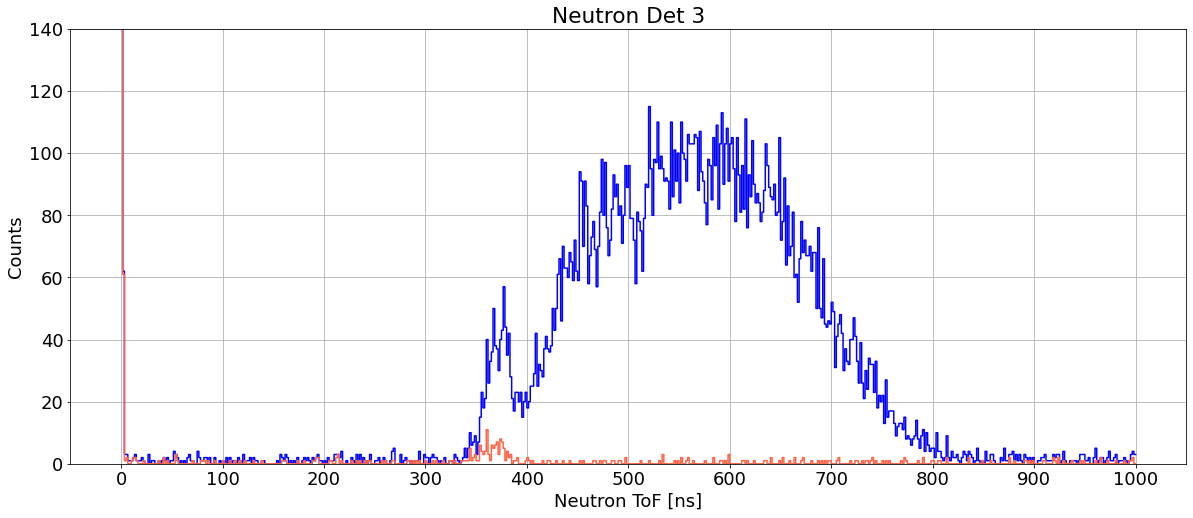

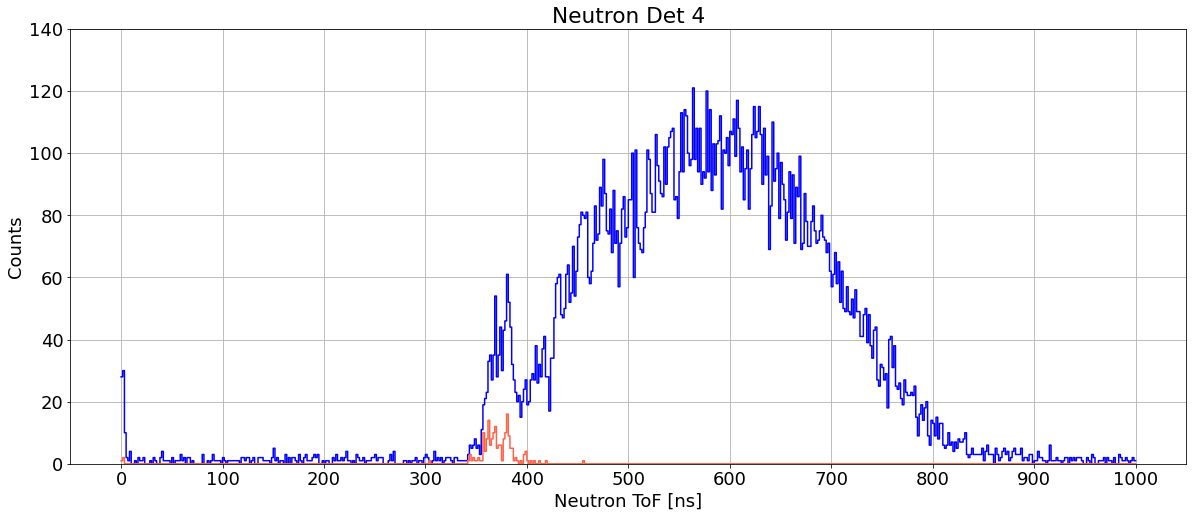

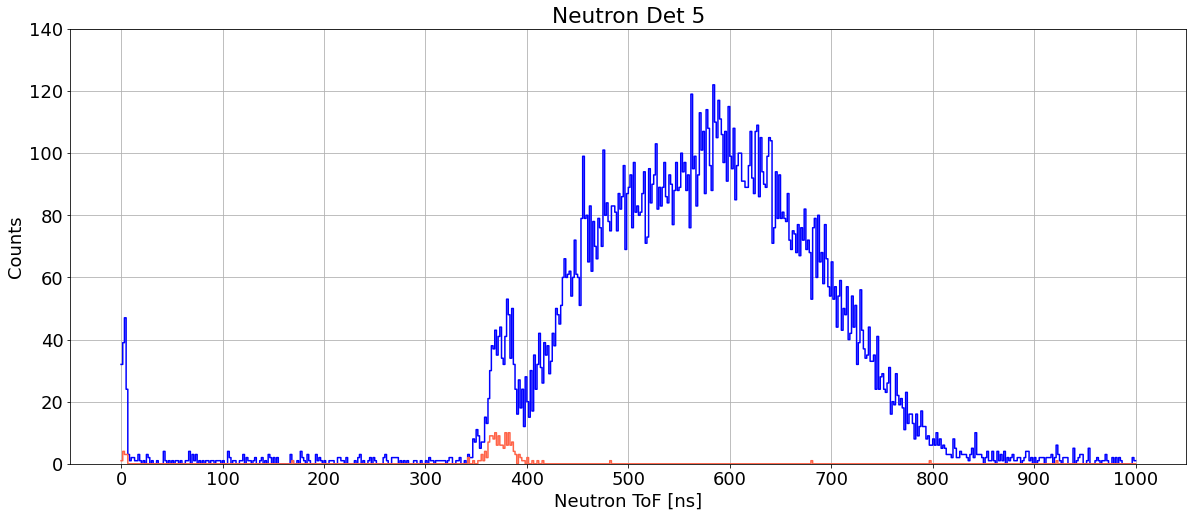

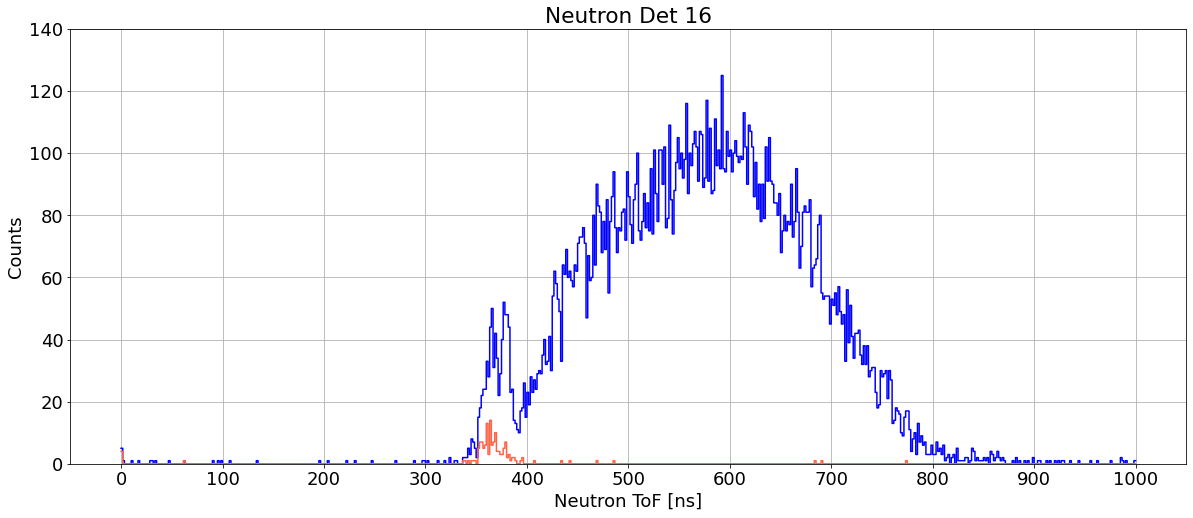

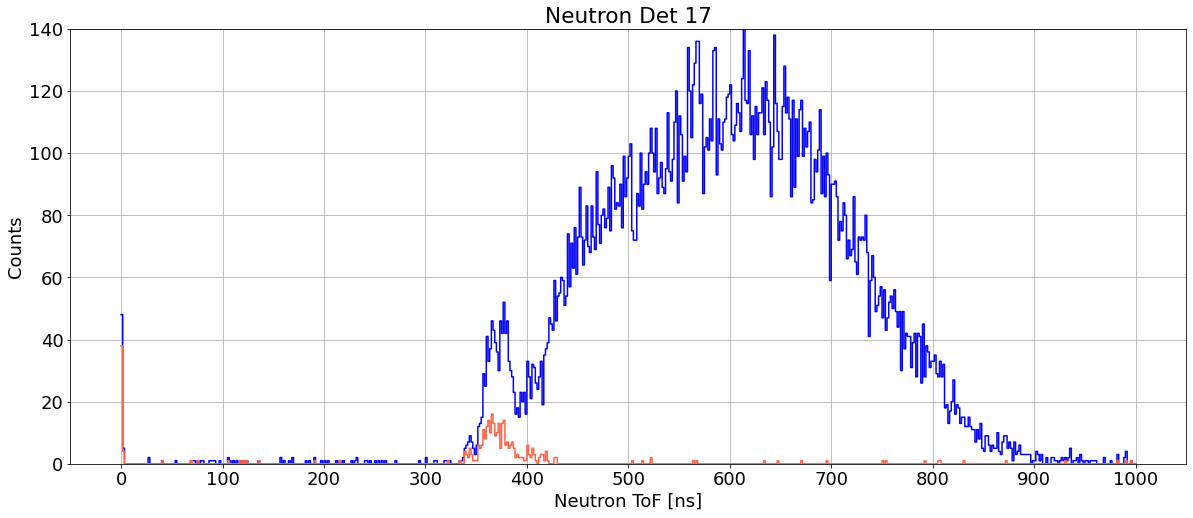

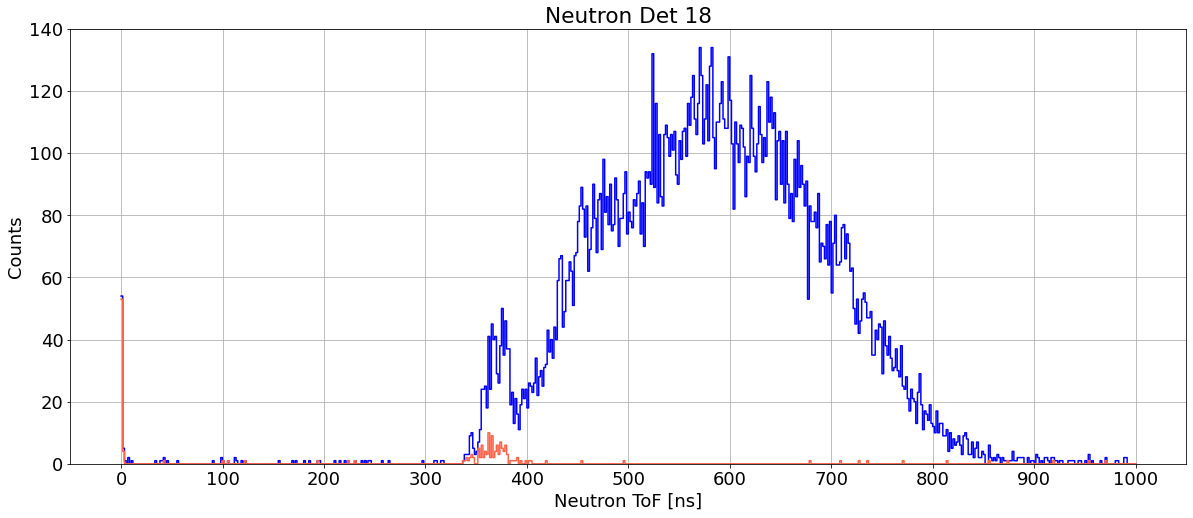

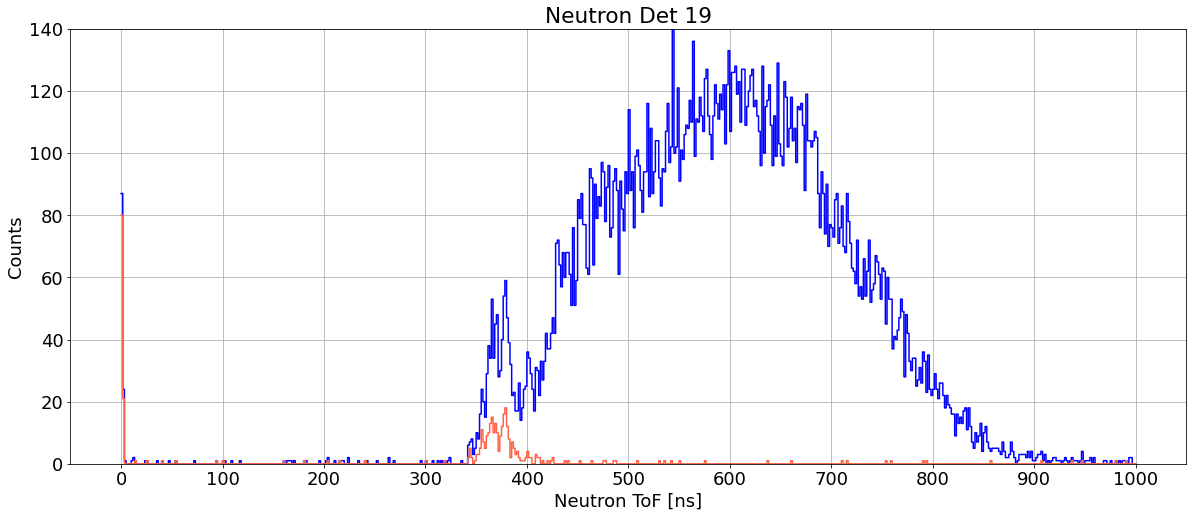

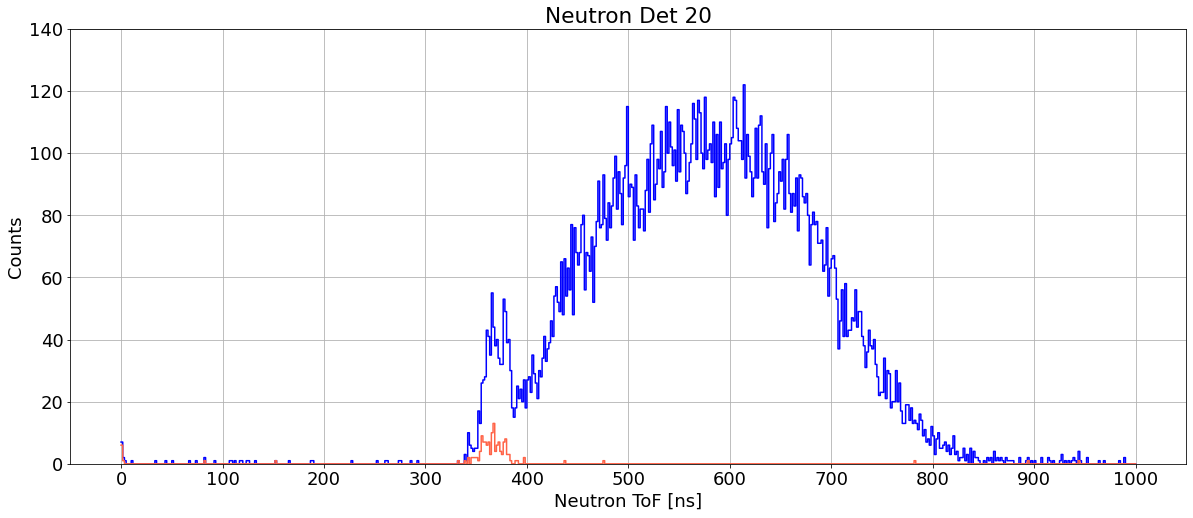

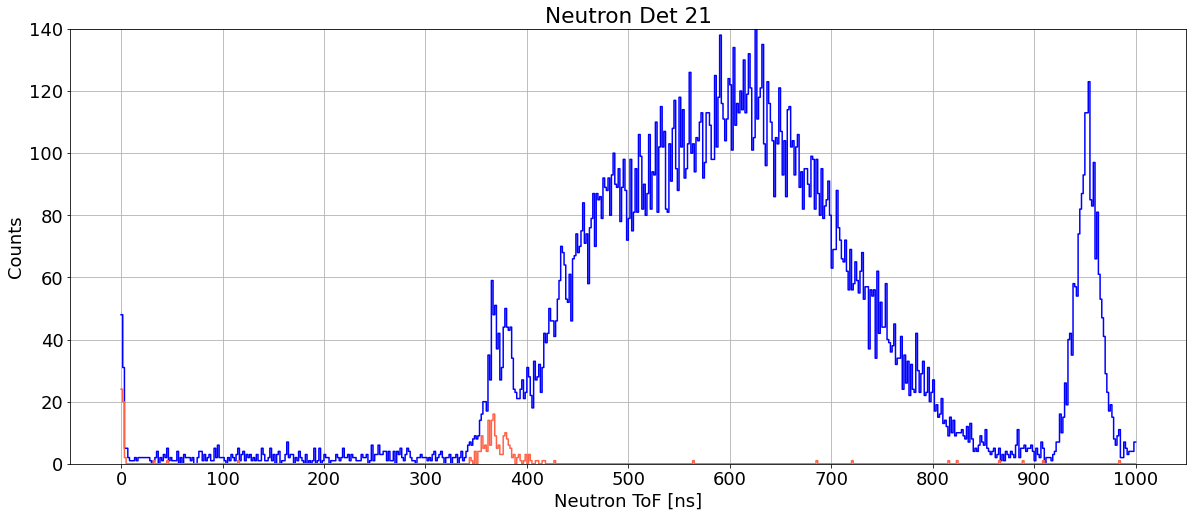

In [50]:
b = 600
r = (0,1000)
chan_nums = [ 0, 1, 2, 3, 4, 5, 16, 17, 18, 19, 20, 21 ]
offsets   = [ 2453, 2450, 2448, 2460, 2442, 2442, 2457, 2451, 2437, 2448, 2445, 2445 ]
ph_cut = [ 7000, 7000, 6500, 6500, 6500, 6500, 6500, 7000, 7000, 7000, 7000, 7000 ]

for i, ch in enumerate( chan_nums ):
    mask = (data['ndet_ch'] == ch) & (data['ndet_PH']<15000)
    phmask = (data['ndet_ch'] == ch) & (data['ndet_PH']>ph_cut[i]) & (data['ndet_PH']<15000)
    
    h_tof = hl.hist( np.fmod(data['ndet_tof'].loc[mask]+(3200-offsets[i]),3200), bins=b, range=r )
    h_tof2 = hl.hist( np.fmod(data['ndet_tof'].loc[phmask]+(3200-offsets[i]),3200), bins=b, range=r )
    fig, ax = plt.subplots(figsize=(20,8))
    hl.plot1d(ax, h_tof, color='blue' )
    hl.plot1d(ax, h_tof2, color='tomato' )
    
    #plt.xlim(0.,1200.)
    plt.ylim(0,140)
    plt.xticks(np.arange(0, 1100, step=100))
    plt.xlabel('Neutron ToF [ns]')
    plt.ylabel('Counts')
    plt.title('Neutron Det {}'.format(ch))
    plt.grid()

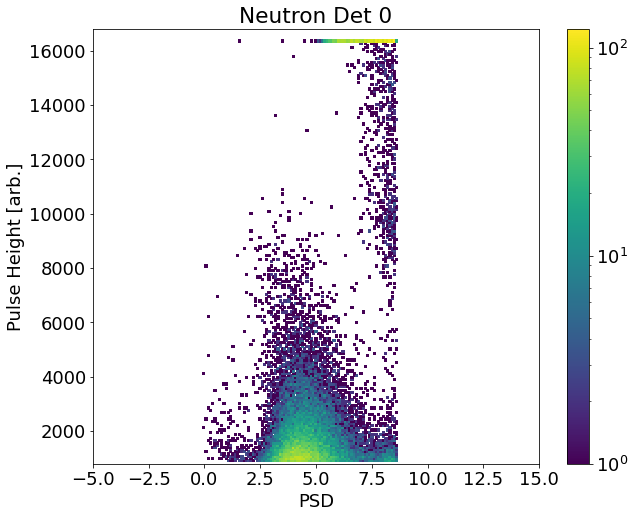

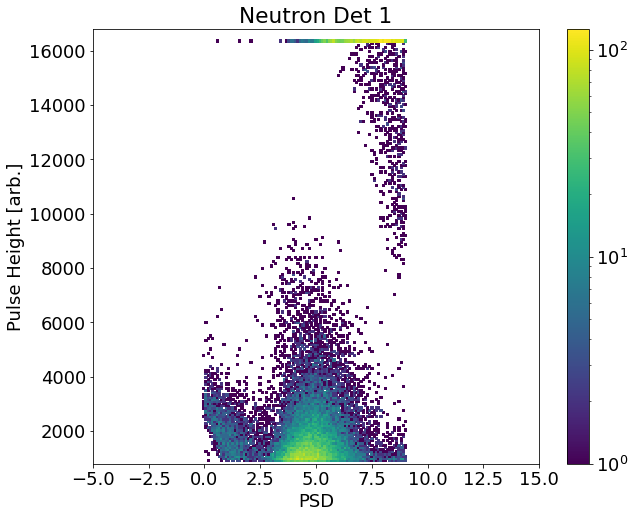

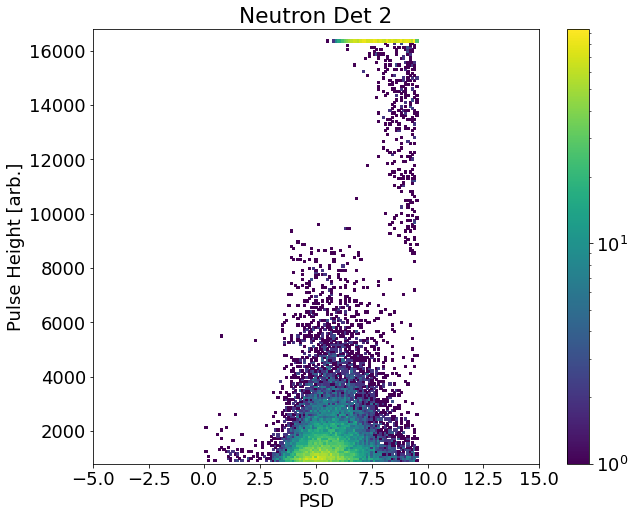

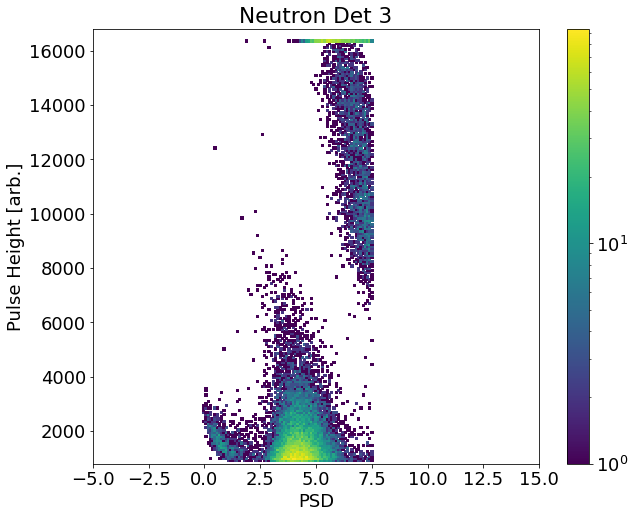

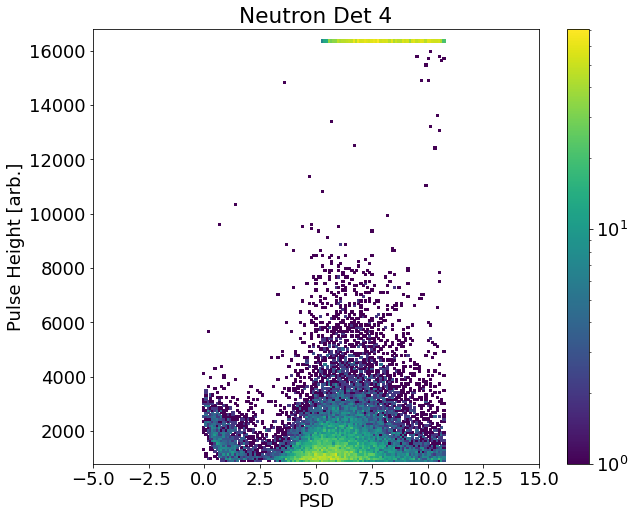

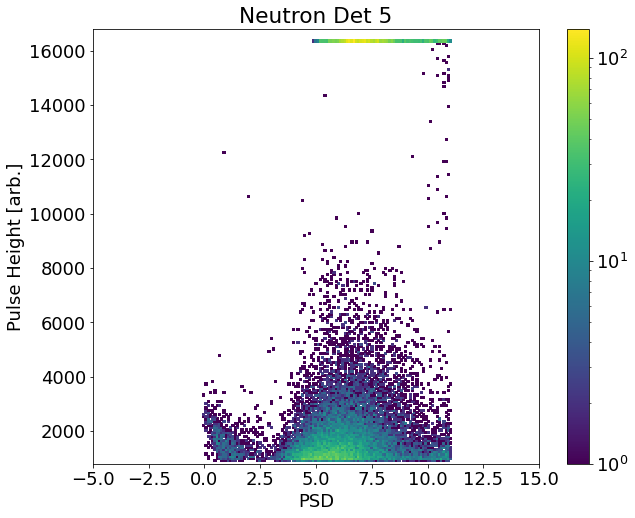

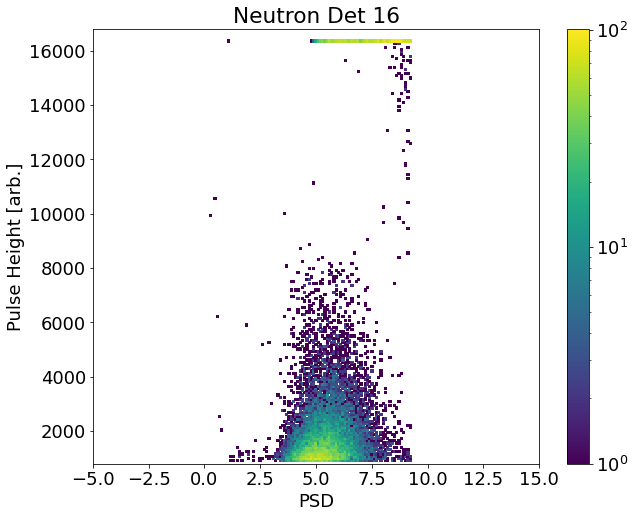

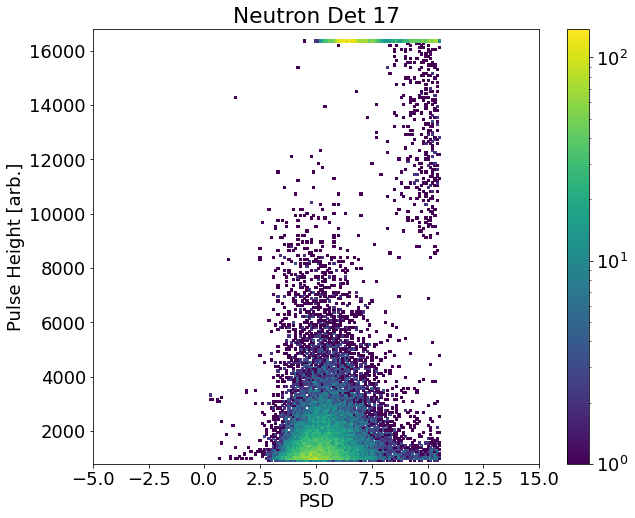

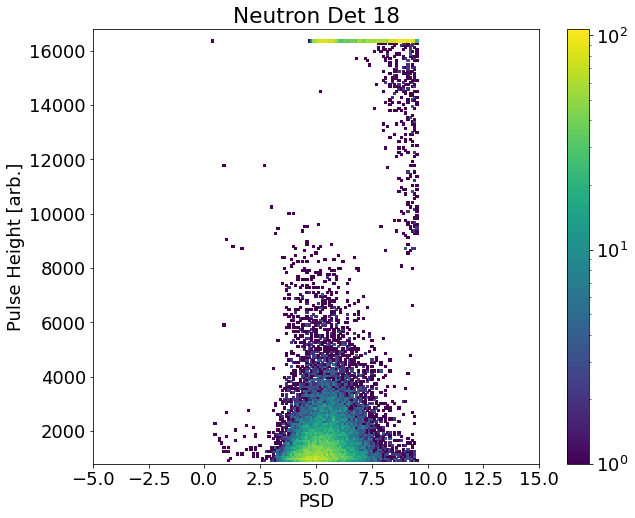

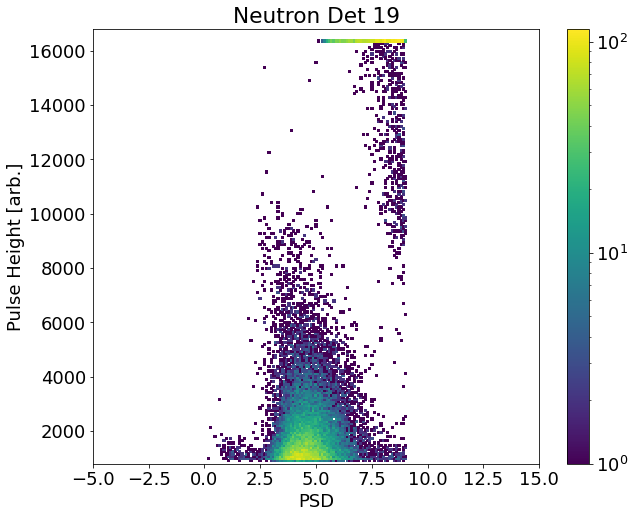

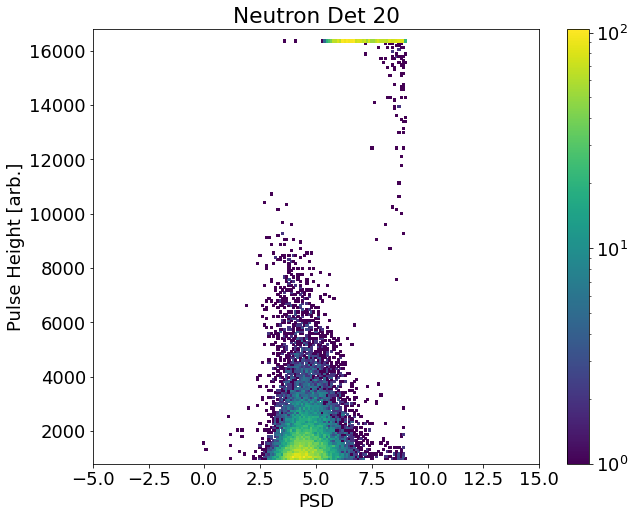

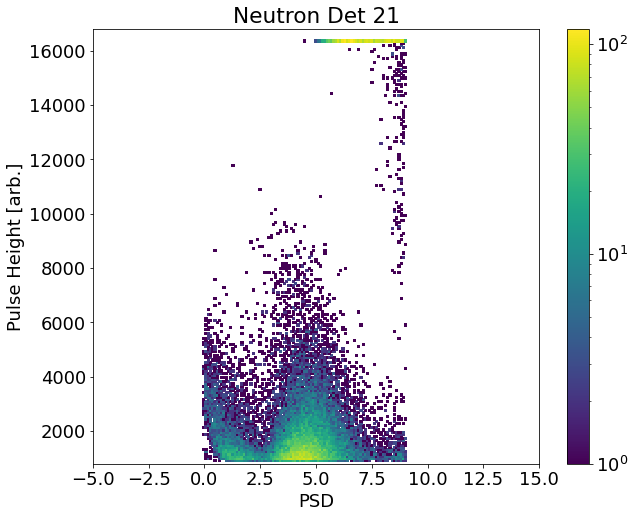

In [11]:
b = 800
r = (0,3200)
chan_nums = [ 0, 1, 2, 3, 4, 5, 16, 17, 18, 19, 20, 21 ]

for i, ch in enumerate( chan_nums ):
    mask = data['ndet_ch'] == ch
    plt.figure(i,figsize=(10,8))
    plt.hist2d( data['ndet_PSD'].loc[mask],\
                 data['ndet_PH'].loc[mask], \
               bins=[np.linspace(-5.,15.,200),np.linspace(800.,16800.,200)],\
                            norm=colors.LogNorm() )
    
    #plt.xlim(0.,1200.)
    #plt.ylim(4.,2e4)

    plt.xlabel('PSD')
    plt.ylabel('Pulse Height [arb.]')
    plt.title('Neutron Det {}'.format(ch))
    plt.colorbar()

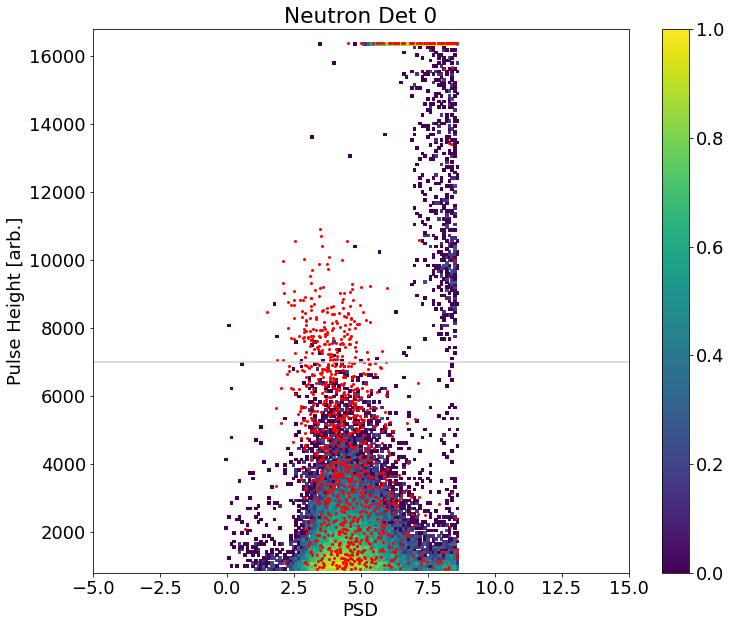

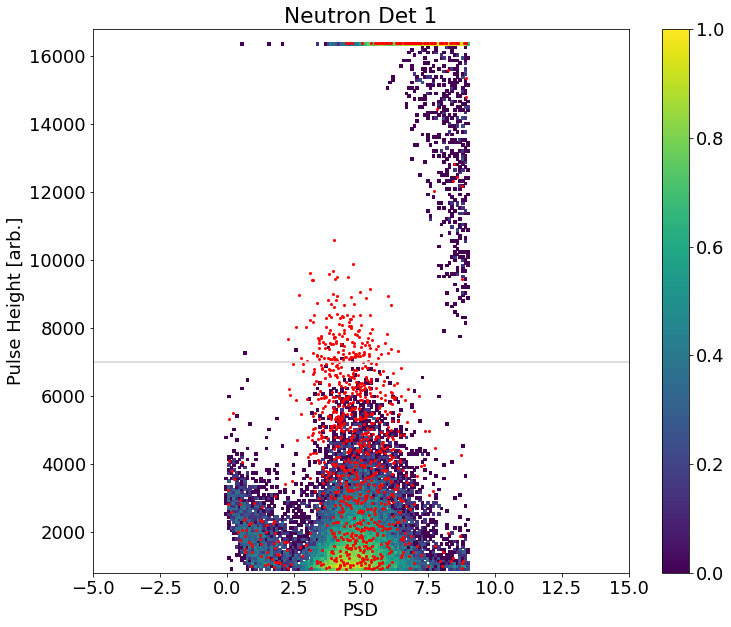

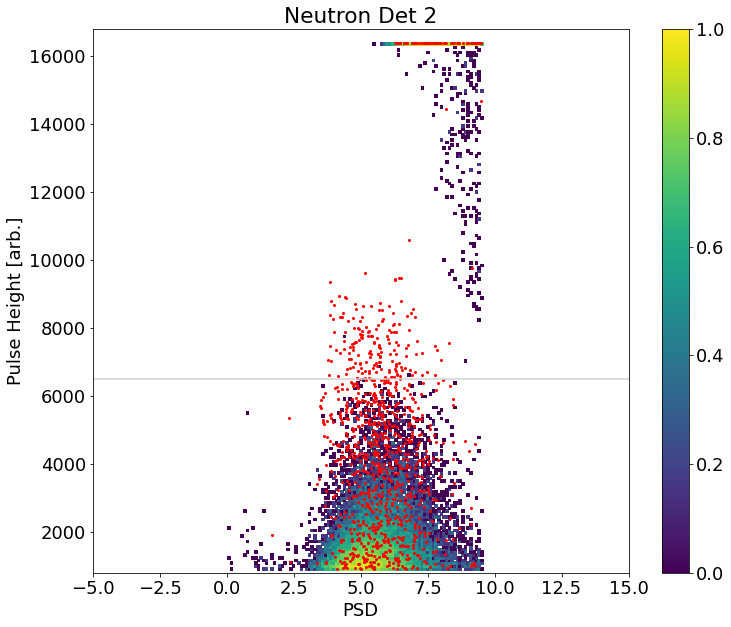

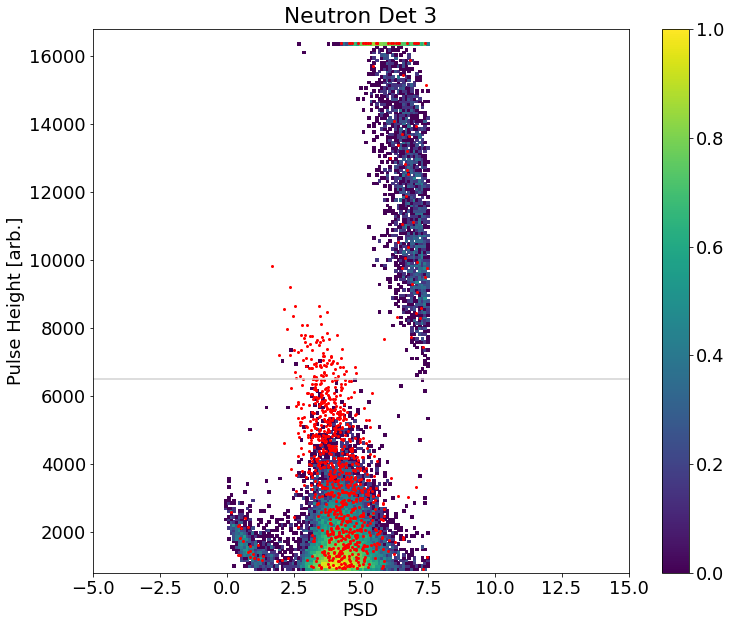

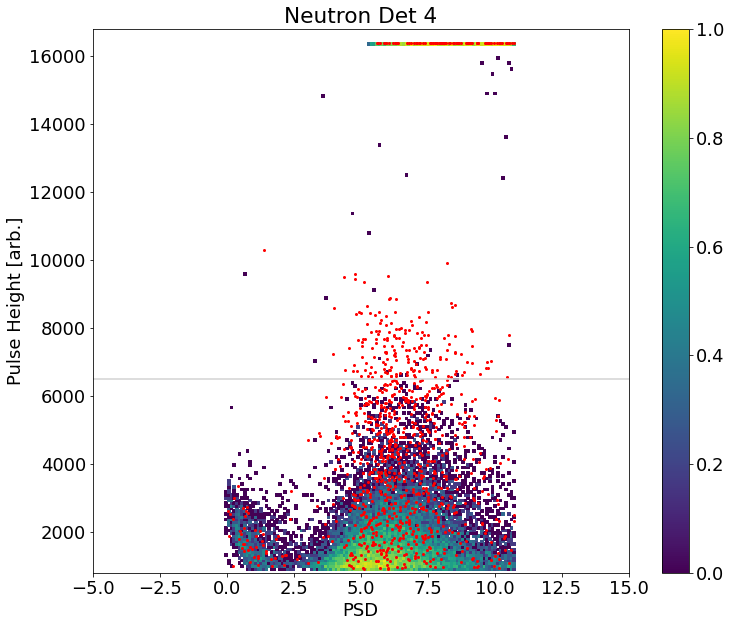

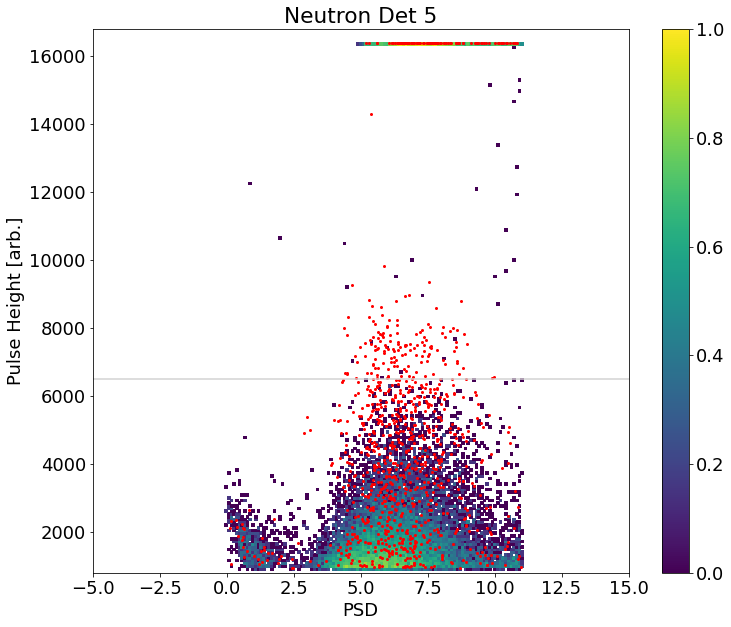

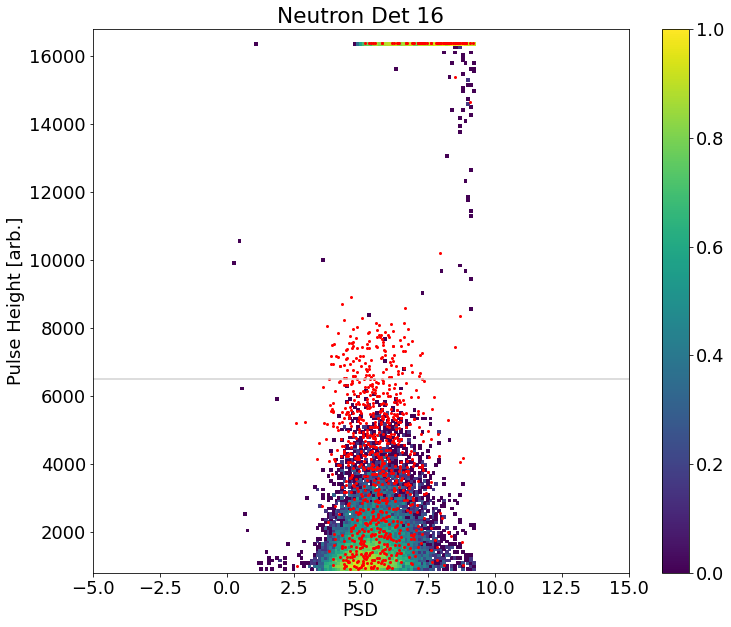

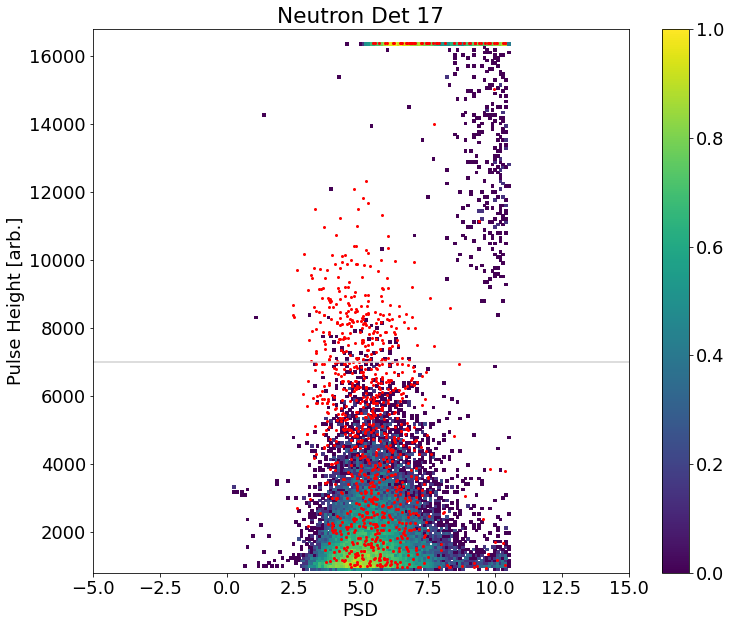

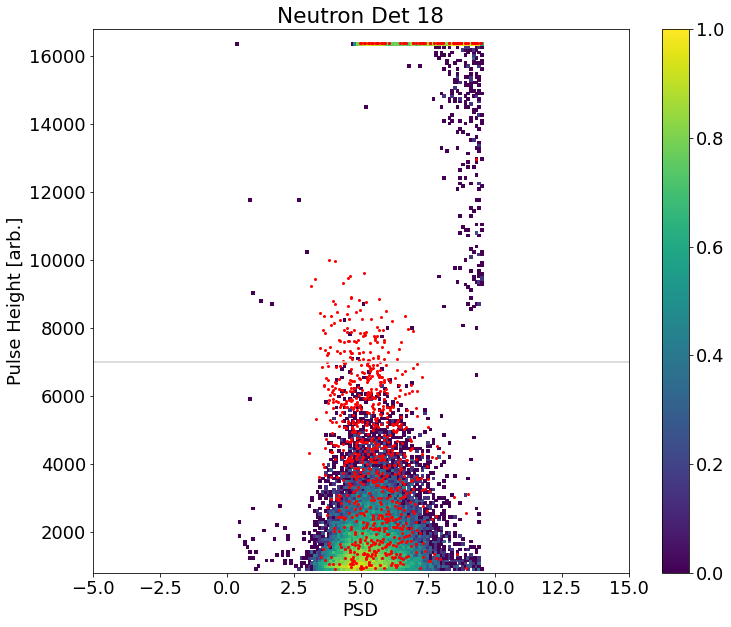

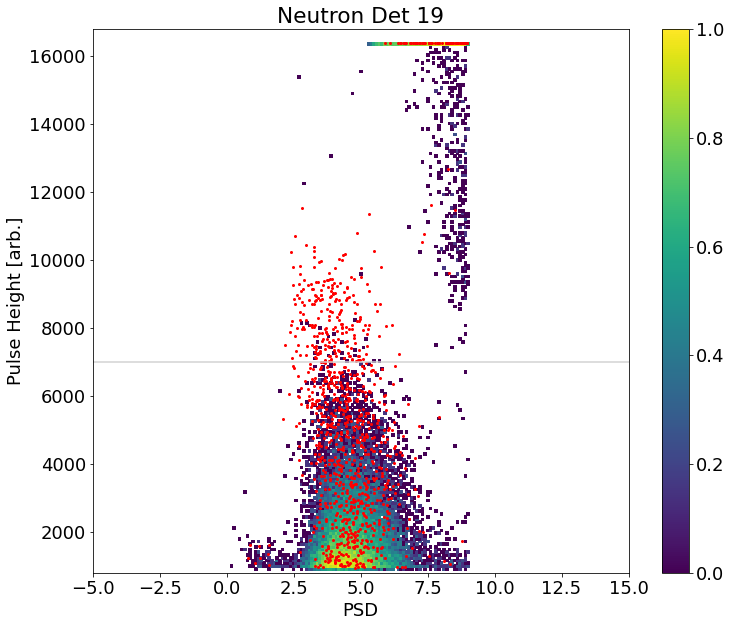

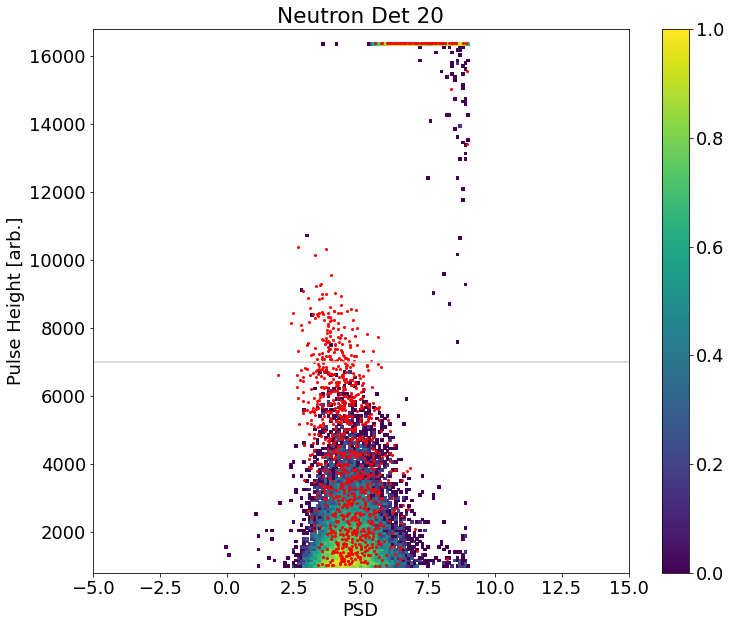

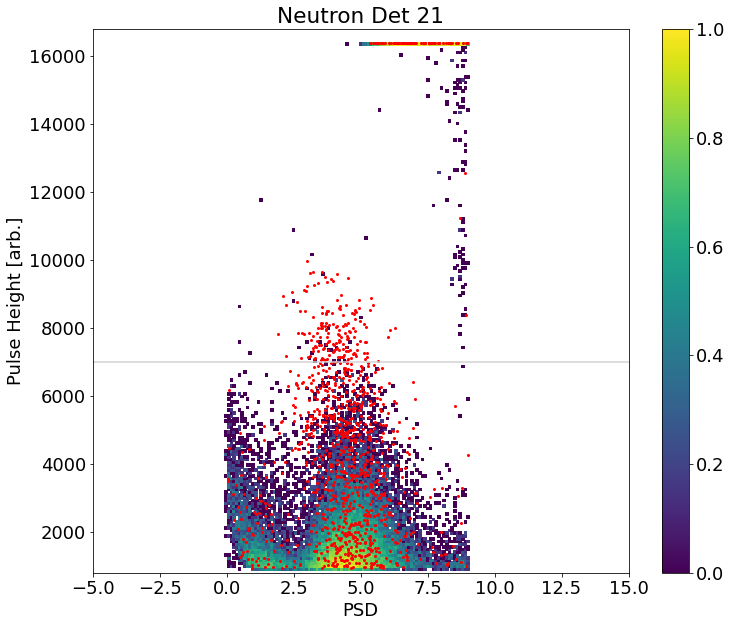

In [43]:
b = 800
r = (0,3200)
chan_nums = [ 0, 1, 2, 3, 4, 5, 16, 17, 18, 19, 20, 21 ]

ph_cut = [ 7000, 7000, 6500, 6500, 6500, 6500, 6500, 7000, 7000, 7000, 7000, 7000 ]

for i, ch in enumerate( chan_nums ):
    le_mask = (data['ndet_ch'] == ch) & \
    (np.fmod(data['ndet_tof']+(3200-offsets[i]),3200)>400)
    #(np.fmod(data['ndet_tof']+(3200-offsets[i]),3200)<400) & \
    #(np.fmod(data['ndet_tof']+(3200-offsets[i]),3200)>300)
    
    he_mask = (data['ndet_ch'] == ch) & \
    (np.fmod(data['ndet_tof']+(3200-offsets[i]),3200)<400) & \
    (np.fmod(data['ndet_tof']+(3200-offsets[i]),3200)>300)
    
    plt.figure(i,figsize=(12,10))
    plt.hist2d( data['ndet_PSD'].loc[le_mask],\
                 data['ndet_PH'].loc[le_mask], \
               bins=[np.linspace(-5.,15.,200),np.linspace(800.,16800.,200)],\
                            norm=colors.LogNorm() )
    
    plt.scatter( data['ndet_PSD'].loc[he_mask],\
                 data['ndet_PH'].loc[he_mask], \
               s=4, color='red' )
    
    plt.hlines(ph_cut[i],-5,15,color='lightgrey')
    
    #plt.xlim(0.,1200.)
    #plt.ylim(4.,2e4)

    plt.xlabel('PSD')
    plt.ylabel('Pulse Height [arb.]')
    plt.title('Neutron Det {}'.format(ch))
    plt.colorbar()